# Genre identification and Song similarity






The dataset has the following files:

genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)

2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

In [ ]:
#Loading basic libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the ML Libraries
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

#For the audio file processing , the updated framework available to public is the librosa package which we use in this study

In [ ]:
#Loading assistive libraries
import librosa
import librosa.display
import IPython.display as ipd

# Why Librosa?
## It provides us with a helper function to convert multichannel to monochannel and also it helpts to convert Sample Rate

# Sample Rate is how the Computer reads the audio file.
## -> measures how frequent the samples of the audio files are
## -> quality or detail of the audio file

### We can say that high sample rate gets more details of each wave in the audio file than low sample rates and also certain sample rates appear same to the eat because our ears can hear most at this rate

In [ ]:
# allows us to list all files to a directory
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#The total available genres in the dataset
dir_ = '/content/drive/My Drive/Dataset/Data'
genre_count = list(os.listdir(f'{dir_}/genres_original/'))
print("The total number of genres in the dataset are : ",len(genre_count))

The total number of genres in the dataset are :  11


In [ ]:
# The number of audio files are :

audio_files = glob("/content/drive/My Drive/Dataset/Data/genres_original/*/*.wav")

print("The total audio files are :",len(audio_files))

The total audio files are : 1000


In [ ]:
#Lets listen to an audio file
ipd.Audio(audio_files[10])

How are we loading the Audio Files?

Here we use librosa and its load() function to read the audio files. We save the ouutputs as 'y' and sr':

## y: raw data of the audio file (numpy array)
## sr: integer value of the sample rate

In [ ]:
y, sr = librosa.load(audio_files[7])

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

y: [-0.02709961 -0.02371216  0.05221558 ... -0.15200806 -0.16900635
 -0.25219727] 

y shape: (661504,) 

Sample Rate (KHz): 22050 



We can see that the raw data of our audiofiles (y) are numpy arrays and in this case our Sample Rate (sr) is 22050.

In [ ]:
audio, _ = librosa.effects.trim(y)

print('Audio File:', audio, '\n')
print('Audio File shape:', np.shape(audio))

Audio File: [-0.02709961 -0.02371216  0.05221558 ... -0.15200806 -0.16900635
 -0.25219727] 

Audio File shape: (661504,)


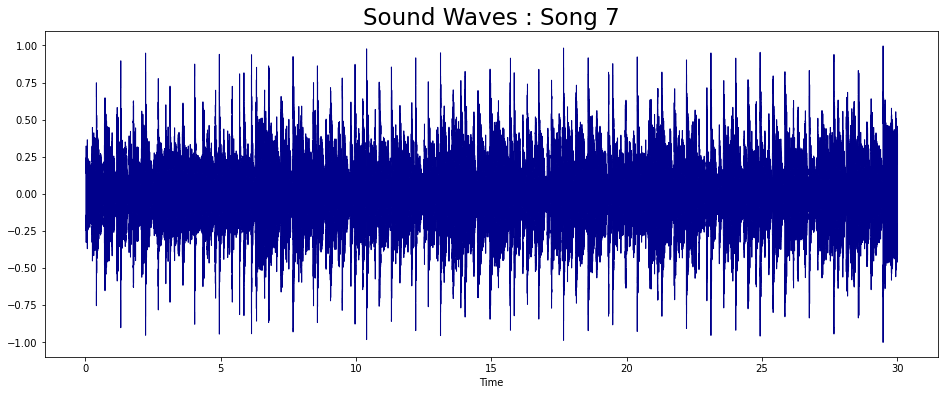

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = sr, color = "#00008B");
plt.title("Sound Waves : Song 7", fontsize = 23);

In [ ]:
ynot, srnot = librosa.load(audio_files[9])

print('y:', ynot, '\n')
print('y shape:', np.shape(ynot), '\n')
print('Sample Rate (KHz):', srnot, '\n')

y: [ 0.0725708  -0.00869751 -0.01080322 ... -0.06570435  0.03738403
 -0.07449341] 

y shape: (661504,) 

Sample Rate (KHz): 22050 



In [ ]:
audionot, _ = librosa.effects.trim(ynot)

print('Audio File:', audionot, '\n')
print('Audio File shape:', np.shape(audionot))

Audio File: [ 0.0725708  -0.00869751 -0.01080322 ... -0.06570435  0.03738403
 -0.07449341] 

Audio File shape: (661504,)


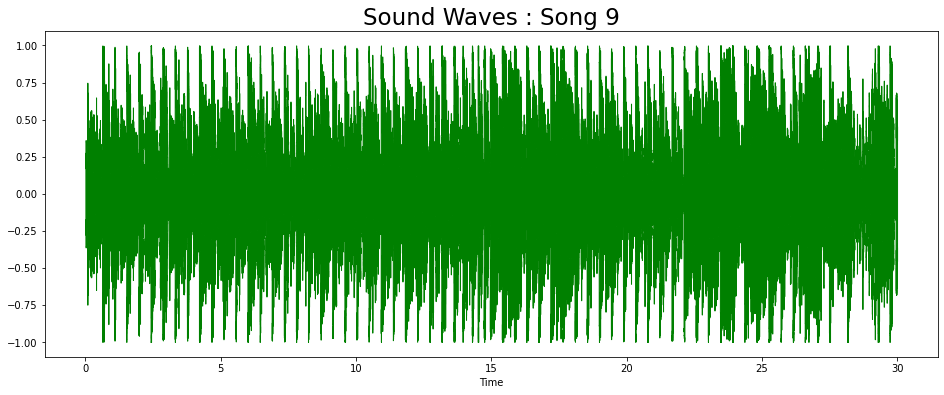

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audionot , sr = sr, color = "Green");
plt.title("Sound Waves : Song 9", fontsize = 23);

By comparing the strengths of the various frequencies, we hope to advance the situation.


We accomplish this by giving the audio data a Fourier transform. This enables us to determine which frequencies are audible at various points throughout the audio recording. The stft() function is employed (Short-time Fourier Transform).


Then, we utilize the amplitude to db function, a widely used audio data converter, to convert the STFT output's amplitude values to decibels (db).
With this, we obtain data that we can use to feed into standard ML models.

In [ ]:
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)


# Use STFT on raw audio data
D = librosa.stft(audio)
Dnot = librosa.stft(audionot)



# convert from aplitude to decibel values by taking the absolute value of D in reference what the max value would be
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_dbnot = librosa.amplitude_to_db(np.abs(Dnot), ref=np.max)



# see the shape of transformed data
print("New shape of transformed data", S_db.shape)
print("New shape of transformed data", S_dbnot.shape)

New shape of transformed data (1025, 1293)
New shape of transformed data (1025, 1293)


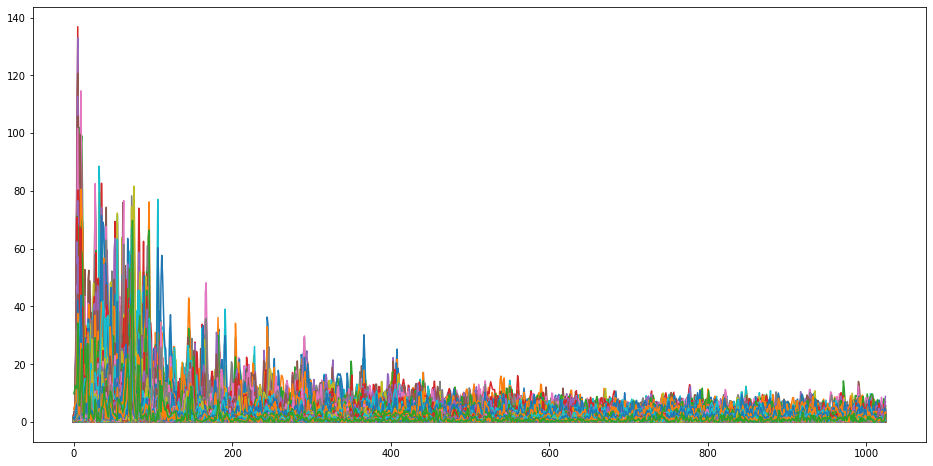

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(np.abs(D))
plt.show(plt.legend)

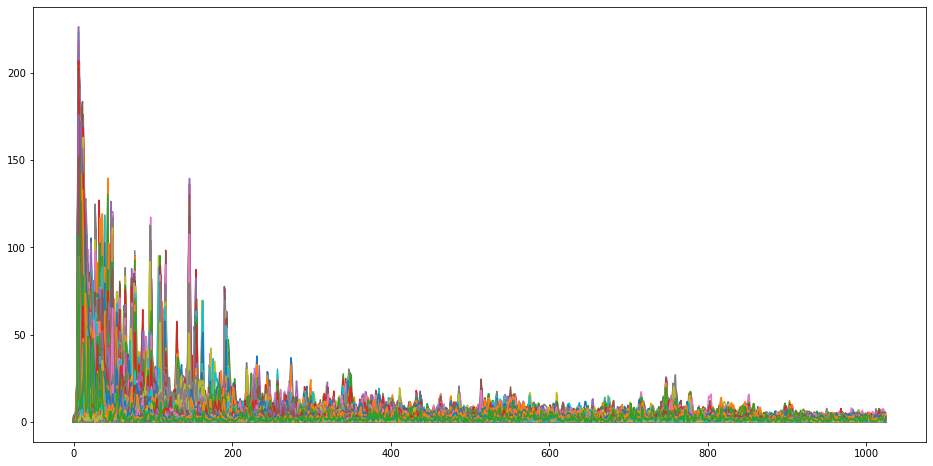

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(np.abs(Dnot))
plt.show(plt.legend)

Now we shall understand the spectrogram.

A spectrogram is a visual representation of the frequency spectrum of a sound signal over time. It displays the amplitude (or strength) of different frequencies present in the audio file as colors or shapes in a 2D graph, with time on the x-axis and frequency on the y-axis. Spectrograms are useful for analyzing and understanding the properties of sounds, identifying components or characteristics of audio signals, and troubleshooting audio-related problems.


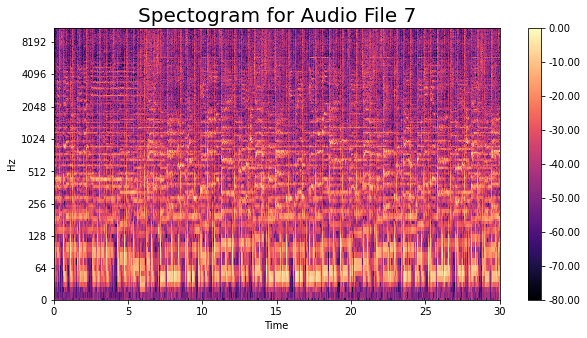

In [ ]:
# plot transformed data as spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectogram for Audio File 7', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

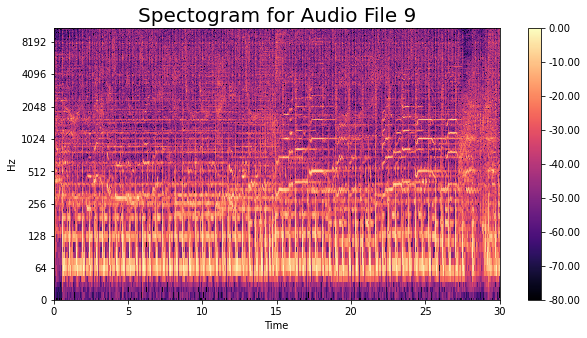

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_dbnot, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectogram for Audio File 9', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

A Mel Spectrogram is a type of spectrogram that is specifically designed to represent the perceived sound characteristics of human hearing. It uses the Mel scale, which is a logarithmic scale that depicts the non-linear frequency response of human ears, to provide a more meaningful representation of the audio signal than a linear frequency scale.

The Mel spectrogram represents the audio signal in terms of its Mel frequency coefficients, and it can be used in various applications such as speech and music processing, sound classification, and feature extraction for machine learning algorithms.

In [ ]:
# apply mel spectogram without STFT
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128*2)
Snot = librosa.feature.melspectrogram(ynot, sr=srnot, n_mels=128*2)

print("Shape of Mel Spectogram for 7", S.shape)
print("Shape of Mel Spectogram for 9", Snot.shape)

Shape of Mel Spectogram for 7 (256, 1293)
Shape of Mel Spectogram for 9 (256, 1293)


In [ ]:
# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
S_db_melnot = librosa.amplitude_to_db(Snot, ref=np.max)

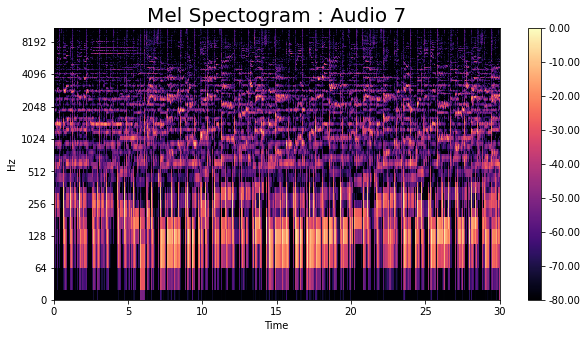

In [ ]:
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram : Audio 7', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

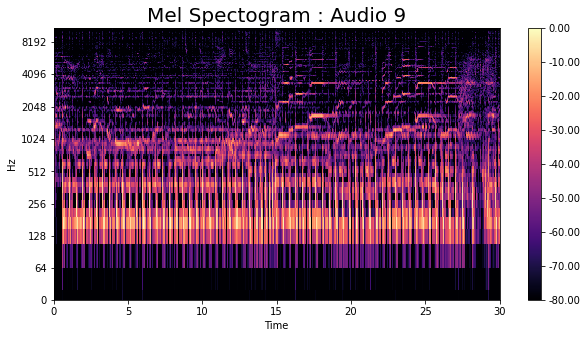

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_melnot, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram : Audio 9', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

Zero Crossing Rate

ZCR is a measure of the number of times the amplitude of a signal crosses the zero axis per unit time i.e. the rate at which the signal changes from positive to negative or back.

To calculate the ZCR of a signal, we first segment the signal into frames of equal length. For each frame, we count the number of times the signal crosses the zero axis. The ZCR for the entire signal can then be computed as the average of the ZCR values for each frame.

In music analysis, the ZCR can be used to identify percussive sounds or changes in rhythm, since percussive sounds tend to have higher ZCR values due to their sharp, short-lived waveforms. It can also be used to identify noise-like segments of a music signal, such as white noise or static.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio, pad=False)
print(sum(zero_crossings))

122656


In [ ]:
zero_crossings_not = librosa.zero_crossings(audionot, pad=False)
print(sum(zero_crossings_not))

87215


Next we use harmonics and perecptruals

Harmonics are characteristichs that human years can't distinguish (represents the sound color)

Perceptrual understanding shock wave represents the sound rhythm and emotion

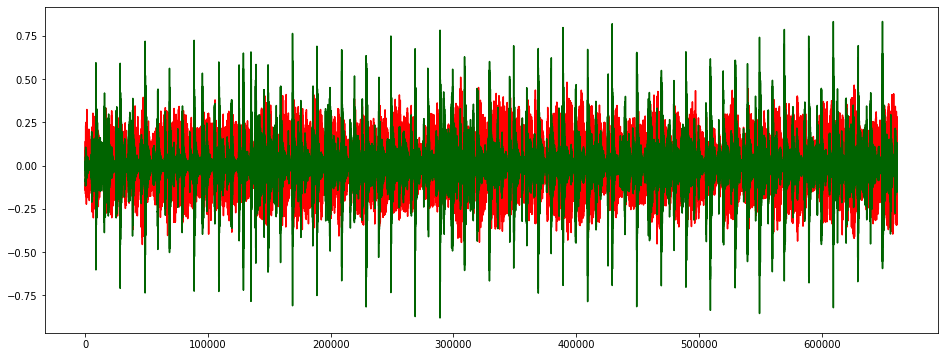

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#FF0000');
plt.plot(y_perc, color = '#006400');

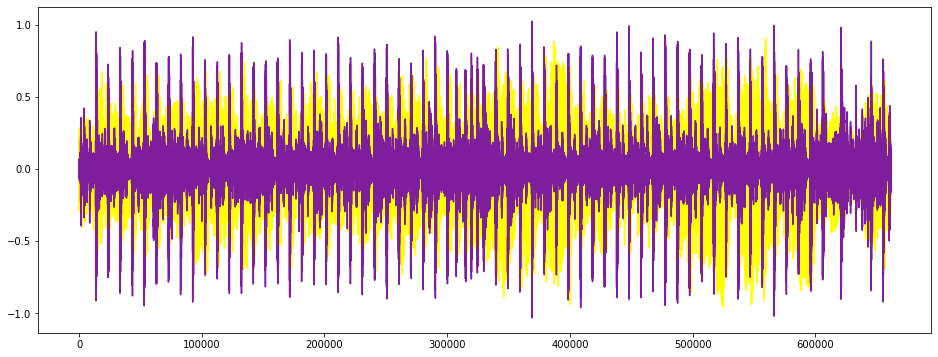

In [ ]:
y_harmnot, y_percnot = librosa.effects.hpss(audionot)

plt.figure(figsize = (16, 6))
plt.plot(y_harmnot, color = '#FFFF00');
plt.plot(y_percnot, color = '#7E1E9C');

Tempo

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

129.19921875

Spectral Centroid

indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

The spectral centroid is a measure of the center of gravity of the frequency content of a signal. It is often used as a descriptor of the tonal center or brightness of a sound.

The spectral centroid is calculated as the weighted mean of the frequencies present in the signal, with the magnitude spectrum of the signal serving as the weights. In other words, it is a way to compute the center of mass of the frequency distribution of a signal.

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [3026.43853529 2926.70599173 2702.86506968 ... 4395.96749675 3714.49648505
 3066.62227798] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


In [ ]:
import sklearn

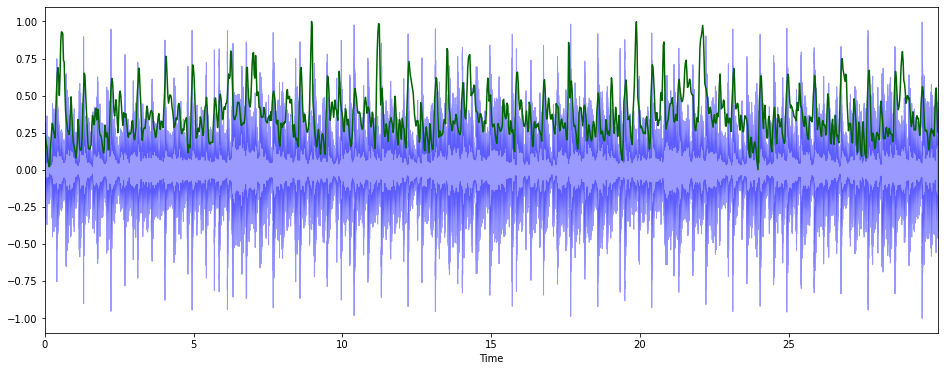

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio, sr=sr, alpha=0.4, color = '#0000FF');
plt.plot(t, normalize(spectral_centroids), color='#006400');

The x-axis represents time in seconds and the y-axis represents amplitude. The green line represents the spectral centroid, with brighter colors indicating a higher value.
This plot can help us visualize the tonal center of the sound, with a higher spectral centroid indicating a brighter or more tonal sound.

In [ ]:
spectral_centroids_not = librosa.feature.spectral_centroid(audionot, sr=srnot)[0]

print('Centroids:', spectral_centroids_not, '\n')
print('Shape of Spectral Centroids:', spectral_centroids_not.shape, '\n')

frame_not = range(len(spectral_centroids_not))

t_not = librosa.frames_to_time(frame_not)

print('frames:', frame_not, '\n')
print('t:', t_not)

Centroids: [2191.46098932 2327.30487959 2572.2407259  ... 4183.15121259 4192.88030936
 4013.65573454] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


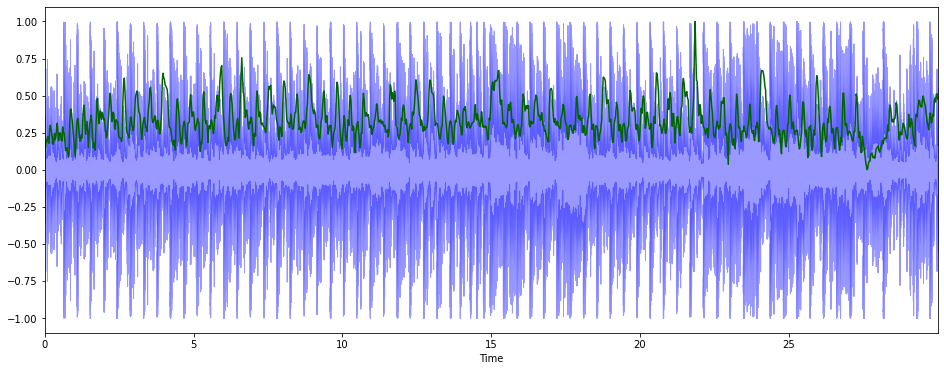

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audionot, sr=srnot, alpha=0.4, color = '#0000FF');
plt.plot(t_not, normalize(spectral_centroids_not), color='#006400');

If the spectral centroid is higher than the waveform, it means that the frequency content of the signal is weighted towards higher frequencies.

Now we use the feature extracted data to understand the audio files

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Dataset/Data/features_3_sec.csv")
df.head(20)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0   blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1   blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2   blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3   blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4   blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
5   blues.00000.5.wav   66149          0.376670         0.089702  0.132618   
6   blues.00000.6.wav   66149          0.379909         0.088827  0.130335   
7   blues.00000.7.wav   66149          0.331880         0.092119  0.140600   
8   blues.00000.8.wav   66149          0.347877         0.094209  0.133130   
9   blues.00000.9.wav   66149          0.358061         0.082957  0.115312   
10  blues.00001.0.wav   66149          0.402401         0.090340  0.093024   
11  blues.00001.1.wav   66149          0.345507         0.091037  0.094656   
12  blues.00001.2.wav   66149          0.338119         0.083682  0.097776   
13  blues.00001.3.wav   66149          0.330751         0.093936  0.085365   
14  blues.00001.4.wav   66149          0.348027         0.100096  0.088437   
15  blues.00001.5.wav   66149          0.329435         0.104149  0.093201   
16  blues.00001.6.wav   66149          0.343666         0.096098  0.089783   
17  blues.00001.7.wav   66149          0.327732         0.099648  0.110633   
18  blues.00001.8.wav   66149          0.329428         0.090254  0.111013   
19  blues.00001.9.wav   66149          0.292987         0.082145  0.094924   

     rms_var  spectral_centroid_mean  spectral_centroid_var  \
0   0.003521             1773.065032          167541.630869   
1   0.001450             1816.693777           90525.690866   
2   0.004620             1788.539719          111407.437613   
3   0.002448             1655.289045          111952.284517   
4   0.001701             1630.656199           79667.267654   
5   0.003583             1994.915219          211700.619569   
6   0.003166             1962.150096          177443.070045   
7   0.002546             1701.890924           35678.130616   
8   0.002538             1746.473502          138073.931244   
9   0.001846             1763.948942           61493.423121   
10  0.003876             1279.182242          406513.816744   
11  0.001495             1513.763969          214768.804443   
12  0.001386             1308.869728          154209.122448   
13  0.002641             1479.530348          646868.373151   
14  0.002204             1729.640428          568827.519152   
15  0.001929             1492.089309          228951.553214   
16  0.002173             1571.420445          257630.094708   
17  0.003306             1877.638297          510311.370648   
18  0.001072             1665.600276          239973.571541   
19  0.003031             1373.437553          210606.446462   

    spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0               1972.744388           117335.771563  ...   39.687145   
1               2010.051501            65671.875673  ...   64.748276   
2               2084.565132            75124.921716  ...   67.336563   
3               1960.039988            82913.639269  ...   47.739452   
4               1948.503884            60204.020268  ...   30.336359   
5               2152.767854            74263.873102  ...   31.448069   
6               2146.503479            98020.541422  ...   33.954071   
7               1979.387612            36670.725886  ...   38.456211   
8               1887.619723           117069.920049  ...   44.311455   
9               1874.195710            51944.921435  ...   43.967834   
10              1921.306192           196573.441648  ...   39.640743   
11              2091.432928           121877.017611  ...   58.940536   
12              1508.008806           111306.051891  ...   63.200188   
13              1906.454247           3577

In [ ]:
df.shape

(9990, 60)

In [ ]:
#df.isnull().sum()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

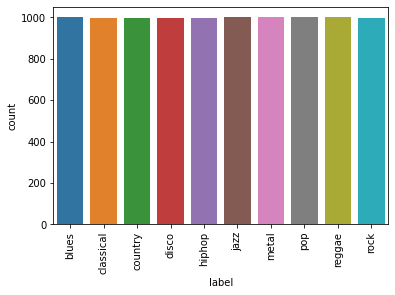

In [ ]:
sns.countplot(x=df.label) # plot the categories
plt.xticks(rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 <a list of 28 Text major ticklabel objects>)

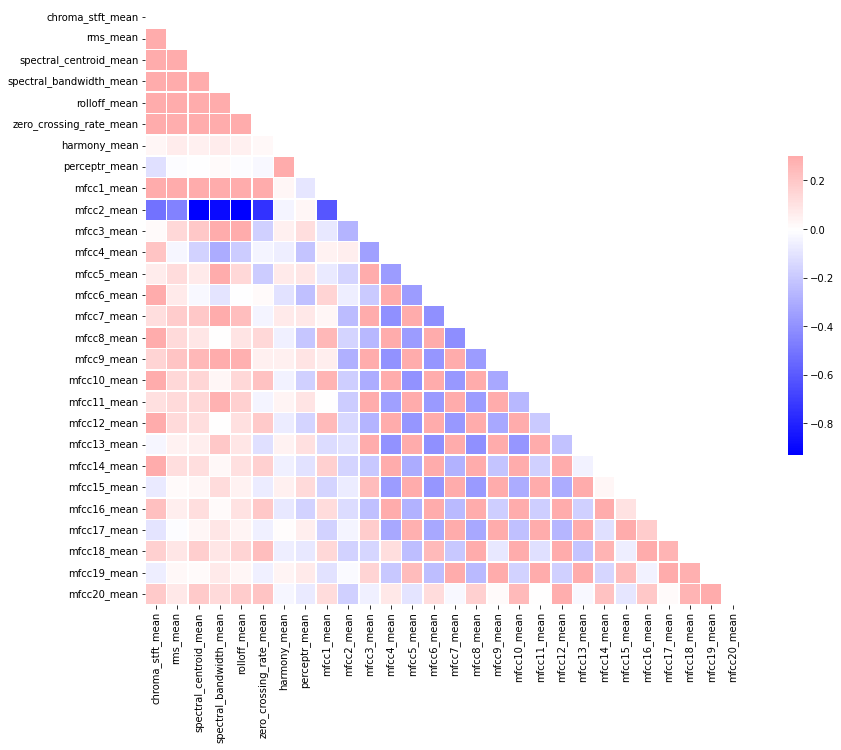

In [ ]:
spike = [col for col in df.columns if 'mean' in col]
corr = df[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11));

sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

Text(0, 0.5, 'BPM')

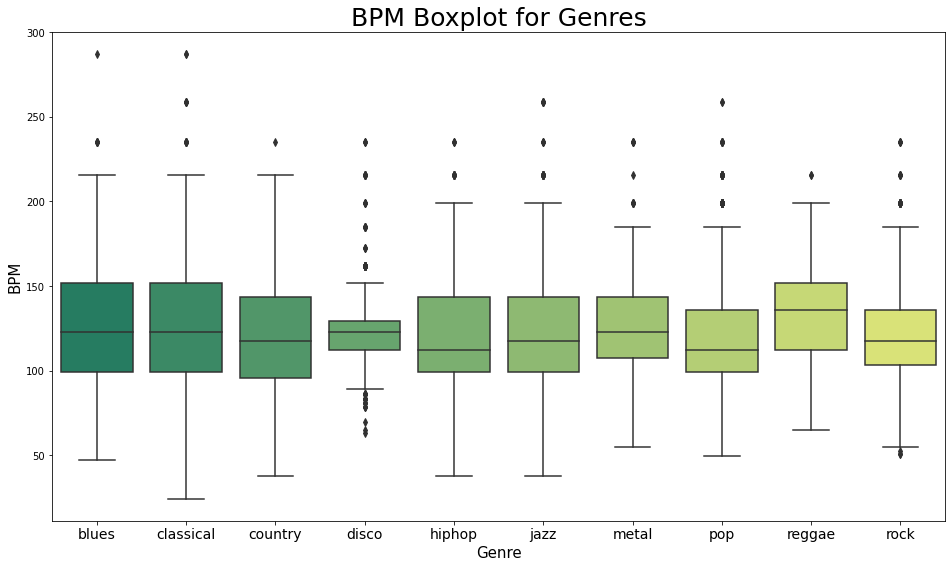

In [ ]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'summer');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
df = df.iloc[0:, 1:]
y = df['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
scaled_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_

array([0.26745621, 0.18238003])

Text(0, 0.5, 'Principal Component 2')

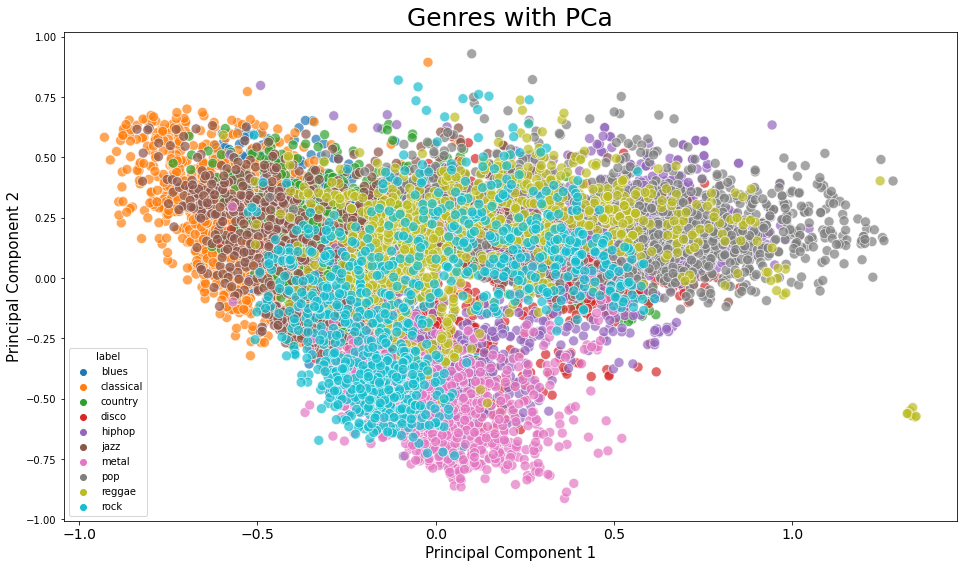

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pca1", y = "pca2", data = fdf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('Genres with PCa', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

In [ ]:
df

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              1972.744388   
1                1816.693777           90525.690866              2010.051501   
2                1788.539719          111407.437613              2084.565132   
3                1655.289045          111952.284517              1960.039988   
4                1630.656199           79667.267654              1948.503884   
...                      ...                    ...                      ...   
9985             1499.083005          164266.886443              1718.707215   
9986             1847.965128          281054.935973              1906.468492   
9987             1346.157659          662956.246325              1561.859087   
9988             2084.515327          203891.039161              2018.366254   
9989             1634.330126          411429.169769              1867.422378   

      spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0              117335.771563   3714.560359  ...   39.687145    -3.241280   
1               65671.875673   3869.682242  ...   64.748276    -6.055294   
2               75124.921716   3997.639160  ...   67.336563    -1.768610   
3               82913.639269   3568.300218  ...   47.739452    -3.841155   
4               60204.020268   3469.992864  ...   30.336359     0.664582   
...                      ...           ...  ...         ...          ...   
9985            85931.574523   3015.559458  ...   42.485981    -9.094270   
9986            99727.037054   3746.694524  ...   32.415203   -12.375726   
9987           138762.841945   2442.362154  ...   78.228149    -2.524483   
9988            22860.992562   4313.266226  ...   28.323744    -5.363541   
9989           119722.211518   3462.042142  ...   38.801735   -11.598399   

      mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0      36.488243     0.722209   38.099152    -5.050335   33.618073   
1      40.677654     0.159015   51.264091    -2.837699   97.030830   
2      28.348579     2.378768   45.717648    -1.938424   53.050835   
3      28.337118     1.218588   34.770935    -3.580352   50.836224   
4      45.880913     1.689446   51.363583    -3.392489   26.738789   
...          ...          ...         ...          ...         ...   
9985   38.326839    -4.246976   31.049839    -5.625813   48.804092   
9986   66.418587    -3.081278   54.414265   -11.960546   63.452255   
9987   21.778994     4.809936   25.980829     1.775686   48.582378   
9988   17.209942     6.462601   21.442928     2.354765   24.843613   
9989   58.983097    -0.178517   55.761299    -6.903252   39.485901   

      mfcc20_mean  mfcc20_var  label  
0       -0.243027   43.771767  blues  
1        5.784063   59.943081  blues  
2        2.517375   33.105122  blues  
3        3.630866   32.023678  blues  
4        0.536961   29.146694  blues  
...           ...         ...    ...  
9985     1.818823   38.966969   rock  
9986     0.428857   18.697033   rock  
9987    -0.299545   41.586990   rock  
9988     0.675824   12.787750   rock  
9989    -

In [ ]:
classes = df.iloc[:,-1]
converter = LabelEncoder()

In [ ]:
y = converter.fit_transform(classes)
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
x = scaler.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [ ]:
print(len(y_test))
print(len(y_train))

2498
7492


Here, we are performing a classification task where we are predicting an isntance is in some category by studying the instance's features.

For the following ML algorithms:

1) Scale the numeric features

2) encode the categorical features

XGBOOST

#n_estimators - number of weak learners to train in each iteration
#learning_rate - contributes to the weights of weak learners and has 1 as a default value.

In [ ]:
import xgboost as xgb


In [ ]:
xgb_classifier = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb_classifier.fit(x_train, y_train)
xgb_predicts = xgb_classifier.predict(x_test)

In [ ]:
xgb_accuracy = accuracy_score(y_test, xgb_predicts)
xgb_accuracy

0.8722978382706165

ADABOOST

AdaBoost is a classification algorithm which calls a given weak learner algorithm repeatedly in a series of rounds. AdaBoost combines a numnber of weak learners to form a strong learner in order to achieve better separation between classes.

In [ ]:
ada_classifier = AdaBoostClassifier(n_estimators = 1000,learning_rate = 1)
ada_classifier.fit(x_train, y_train)
ada_predicts = ada_classifier.predict(x_test)

In [ ]:
ada_accuracy = accuracy_score(y_test, ada_predicts)
ada_accuracy

0.3718975180144115

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(x_train, y_train)
knn_predicts = knn.predict(x_test)

In [ ]:
knn_accuracy = accuracy_score(y_test, knn_predicts)
knn_accuracy

0.8158526821457166

SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(decision_function_shape="ovo")
svm.fit(x_train, y_train)
svm_predicts = svm.predict(x_test)

In [ ]:
svm_accuracy = accuracy_score(y_test, svm_predicts)
svm_accuracy

0.7389911929543634

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rforest.fit(x_train, y_train)
rforest_predicts = rforest.predict(x_test)

In [ ]:
rforest_accuracy = accuracy_score(y_test, rforest_predicts)
rforest_accuracy

0.8010408326661329

Decison Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
tree_predicts = tree.predict(x_test)

In [ ]:
tree_accuracy = accuracy_score(y_test, tree_predicts)
tree_accuracy

0.6305044035228182

XGB is the model

confusion matrix is calculated

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [ ]:
cm = confusion_matrix(y_test, xgb_predicts)
np.set_printoptions(precision=5, suppress=True)

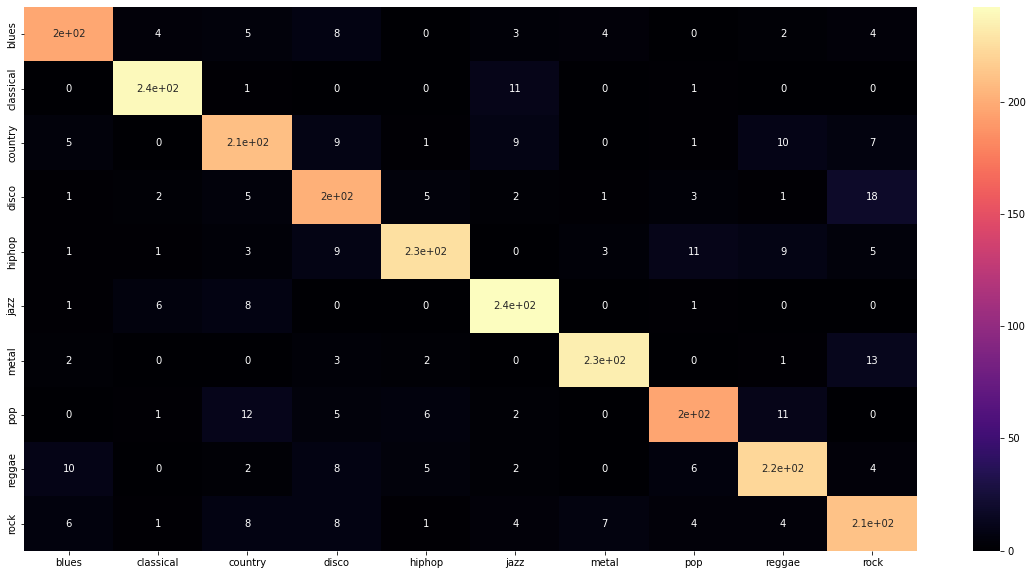

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(cm, cmap="magma", annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [ ]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 15.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=7c7d9bed9c70862dd8e52604bea3e733ace40b2bcf91780a0313786fc786dbf9
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompat

In [ ]:
#finding similar songs using cosine similarity

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Dataset/Data/features_30_sec.csv", index_col='filename')

In [ ]:
genres = df[['label']]

In [ ]:
genres

label
filename              
blues.00000.wav  blues
blues.00001.wav  blues
blues.00002.wav  blues
blues.00003.wav  blues
blues.00004.wav  blues
...                ...
rock.00095.wav    rock
rock.00096.wav    rock
rock.00097.wav    rock
rock.00098.wav    rock
rock.00099.wav    rock

[1000 rows x 1 columns]

In [ ]:
df = df.drop(columns=['length','label'])
df

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
filename                                                                 
blues.00000.wav          0.350088         0.088757  0.130228  0.002827   
blues.00001.wav          0.340914         0.094980  0.095948  0.002373   
blues.00002.wav          0.363637         0.085275  0.175570  0.002746   
blues.00003.wav          0.404785         0.093999  0.141093  0.006346   
blues.00004.wav          0.308526         0.087841  0.091529  0.002303   
...                           ...              ...       ...       ...   
rock.00095.wav           0.352063         0.080487  0.079486  0.000345   
rock.00096.wav           0.398687         0.075086  0.076458  0.000588   
rock.00097.wav           0.432142         0.075268  0.081651  0.000322   
rock.00098.wav           0.362485         0.091506  0.083860  0.001211   
rock.00099.wav           0.358401         0.085884  0.054454  0.000336   

                 spectral_centroid_mean  spectral_centroid_var  \
filename                                                         
blues.00000.wav             1784.165850          129774.064525   
blues.00001.wav             1530.176679          375850.073649   
blues.00002.wav             1552.811865          156467.643368   
blues.00003.wav             1070.106615          184355.942417   
blues.00004.wav             1835.004266          343399.939274   
...                                 ...                    ...   
rock.00095.wav              2008.149458          282174.689224   
rock.00096.wav              2006.843354          182114.709510   
rock.00097.wav              2077.526598          231657.968040   
rock.00098.wav              1398.699344          240318.731073   
rock.00099.wav              1609.795082          422203.216152   

                 spectral_bandwidth_mean  spectral_bandwidth_var  \
filename                                                           
blues.00000.wav              2002.449060            85882.761315   
blues.00001.wav              2039.036516           213843.755497   
blues.00002.wav              1747.702312            76254.192257   
blues.00003.wav              1596.412872           166441.494769   
blues.00004.wav              1748.172116            88445.209036   
...                                  ...                     ...   
rock.00095.wav               2106.541053            88609.749506   
rock.00096.wav               2068.942009            82426.016726   
rock.00097.wav               1927.293153            74717.124394   
rock.00098.wav               1818.450280           109090.207161   
rock.00099.wav               1797.213044           120115.632927   

                 rolloff_mean   rolloff_var  ...  mfcc16_mean  mfcc16_var  \
filename                                     ...                            
blues.00000.wav   3805.839606  9.015054e+05  ...     0.752740   52.420910   
blues.00001.wav   3550.522098  2.977893e+06  ...     0.927998   55.356403   
blues.00002.wav   3042.260232  7.840345e+05  ...     2.451690   40.598766   
blues.00003.wav   2184.745799  1.493194e+06  ...     0.780874   44.427753   
blues.00004.wav   3579.757627  1.572978e+06  ...    -4.520576   86.099236   
...                       ...           ...  ...          ...         ...   
rock.00095.wav    4253.557033  1.222421e+06  ...     1.789867   45.050526   
rock.00096.wav    4149.338328  1.046621e+06  ...     3.739020   33.851742   
rock.00097.wav    4031.405321  8.042154e+05  ...     1.838090   33.597008   
rock.00098.wav    3015.631004  1.332712e+06  ...    -2.812176   46.324894   
rock.00099.wav    3246.908930  1.753476e+06  ...     1.794104   59.167755   

                 mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
filename                                                            
blues.00000.wav    -1.690215   36.524071    -0.408979   41.597103   
blues.00001.wav    -0.731125   60.314529     0.295073   48.120598   
blues.00002.wav    -7.729093   4

In [ ]:
#scaling the data
df_scaled = preprocessing.scale(df)

In [ ]:
similars = cosine_similarity(df_scaled)

In [ ]:
similars

array([[ 1.     ,  0.04923,  0.58962, ...,  0.49629,  0.28496,  0.3041 ],
       [ 0.04923,  1.     , -0.09683, ..., -0.30257,  0.49956,  0.31172],
       [ 0.58962, -0.09683,  1.     , ...,  0.58998,  0.21638,  0.32107],
       ...,
       [ 0.49629, -0.30257,  0.58998, ...,  1.     ,  0.28716,  0.41517],
       [ 0.28496,  0.49956,  0.21638, ...,  0.28716,  1.     ,  0.58904],
       [ 0.3041 ,  0.31172,  0.32107, ...,  0.41517,  0.58904,  1.     ]])

In [ ]:
sim = pd.DataFrame(similars)
sim

0         1         2         3         4         5         6    \
0    1.000000  0.049231  0.589618  0.284862  0.025561 -0.346688 -0.219483   
1    0.049231  1.000000 -0.096834  0.520903  0.080749  0.307856  0.318286   
2    0.589618 -0.096834  1.000000  0.210411  0.400266 -0.082019 -0.028061   
3    0.284862  0.520903  0.210411  1.000000  0.126437  0.134796  0.300746   
4    0.025561  0.080749  0.400266  0.126437  1.000000  0.556066  0.482195   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.610942 -0.077301  0.495707 -0.000287  0.063454 -0.231012 -0.251086   
996  0.640835 -0.222119  0.566837  0.020515  0.063546 -0.272209 -0.291506   
997  0.496294 -0.302573  0.589983 -0.107821  0.172944 -0.175960 -0.203014   
998  0.284958  0.499562  0.216378  0.502279  0.153192  0.176351  0.252338   
999  0.304098  0.311723  0.321069  0.183210  0.061785  0.052447  0.065553   

          7         8         9    ...       990       991       992  \
0   -0.167626  0.641877 -0.097889  ... -0.082829  0.546169  0.578558   
1    0.415258  0.120649  0.404168  ... -0.098111 -0.325126 -0.370792   
2    0.104446  0.468113 -0.132532  ... -0.032408  0.561074  0.590779   
3    0.324566  0.352758  0.295184  ... -0.320107 -0.206516 -0.151132   
4    0.623455  0.029703  0.471657  ...  0.087605  0.017366  0.138035   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.180628  0.619450 -0.258421  ...  0.023926  0.843727  0.851726   
996 -0.256171  0.612170 -0.304636  ... -0.033826  0.871226  0.882825   
997 -0.155732  0.461320 -0.330066  ... -0.008336  0.914170  0.926558   
998  0.239441  0.454673  0.229392  ... -0.233309  0.117855  0.161883   
999  0.068649  0.403862  0.083416  ...  0.032065  0.330570  0.257530   

          993       994       995       996       997       998       999  
0    0.662590  0.571629  0.610942  0.640835  0.496294  0.284958  0.304098  
1   -0.191698 -0.330834 -0.077301 -0.222119 -0.302573  0.499562  0.311723  
2    0.583293  0.514537  0.495707  0.566837  0.589983  0.216378  0.321069  
3    0.041986 -0.172515 -0.000287  0.020515 -0.107821  0.502279  0.183210  
4    0.104684 -0.034594  0.063454  0.063546  0.172944  0.153192  0.061785  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.860594  0.851456  1.000000  0.902064  0.865241  0.349870  0.522483  
996  0.880362  0.863062  0.902064  1.000000  0.902071  0.337834  0.472331  
997  0.897654  0.878851  0.865241  0.902071  1.000000  0.287157  0.415173  
998  0.327933  0.157977  0.349870  0.337834  0.287157  1.000000  0.589041  
999  0.435572  0.329604  0.522483  0.472331  0.415173  0.589041  1.000000  

[1000 rows x 1000 columns]

In [ ]:
sim_names = sim.set_index(genres.index)
sim_names

0         1         2         3         4         5    \
filename                                                                      
blues.00000.wav  1.000000  0.049231  0.589618  0.284862  0.025561 -0.346688   
blues.00001.wav  0.049231  1.000000 -0.096834  0.520903  0.080749  0.307856   
blues.00002.wav  0.589618 -0.096834  1.000000  0.210411  0.400266 -0.082019   
blues.00003.wav  0.284862  0.520903  0.210411  1.000000  0.126437  0.134796   
blues.00004.wav  0.025561  0.080749  0.400266  0.126437  1.000000  0.556066   
...                   ...       ...       ...       ...       ...       ...   
rock.00095.wav   0.610942 -0.077301  0.495707 -0.000287  0.063454 -0.231012   
rock.00096.wav   0.640835 -0.222119  0.566837  0.020515  0.063546 -0.272209   
rock.00097.wav   0.496294 -0.302573  0.589983 -0.107821  0.172944 -0.175960   
rock.00098.wav   0.284958  0.499562  0.216378  0.502279  0.153192  0.176351   
rock.00099.wav   0.304098  0.311723  0.321069  0.183210  0.061785  0.052447   

                      6         7         8         9    ...       990  \
filename                                                 ...             
blues.00000.wav -0.219483 -0.167626  0.641877 -0.097889  ... -0.082829   
blues.00001.wav  0.318286  0.415258  0.120649  0.404168  ... -0.098111   
blues.00002.wav -0.028061  0.104446  0.468113 -0.132532  ... -0.032408   
blues.00003.wav  0.300746  0.324566  0.352758  0.295184  ... -0.320107   
blues.00004.wav  0.482195  0.623455  0.029703  0.471657  ...  0.087605   
...                   ...       ...       ...       ...  ...       ...   
rock.00095.wav  -0.251086 -0.180628  0.619450 -0.258421  ...  0.023926   
rock.00096.wav  -0.291506 -0.256171  0.612170 -0.304636  ... -0.033826   
rock.00097.wav  -0.203014 -0.155732  0.461320 -0.330066  ... -0.008336   
rock.00098.wav   0.252338  0.239441  0.454673  0.229392  ... -0.233309   
rock.00099.wav   0.065553  0.068649  0.403862  0.083416  ...  0.032065   

                      991       992       993       994       995       996  \
filename                                                                      
blues.00000.wav  0.546169  0.578558  0.662590  0.571629  0.610942  0.640835   
blues.00001.wav -0.325126 -0.370792 -0.191698 -0.330834 -0.077301 -0.222119   
blues.00002.wav  0.561074  0.590779  0.583293  0.514537  0.495707  0.566837   
blues.00003.wav -0.206516 -0.151132  0.041986 -0.172515 -0.000287  0.020515   
blues.00004.wav  0.017366  0.138035  0.104684 -0.034594  0.063454  0.063546   
...                   ...       ...       ...       ...       ...       ...   
rock.00095.wav   0.843727  0.851726  0.860594  0.851456  1.000000  0.902064   
rock.00096.wav   0.871226  0.882825  0.880362  0.863062  0.902064  1.000000   
rock.00097.wav   0.914170  0.926558  0.897654  0.878851  0.865241  0.902071   
rock.00098.wav   0.117855  0.161883  0.327933  0.157977  0.349870  0.337834   
rock.00099.wav   0.330570  0.257530  0.435572  0.329604  0.522483  0.472331   

                      997       998       999  
filename                                       
blues.00000.wav  0.496294  0.284958  0.304098  
blues.00001.wav -0.302573  0.499562  0.311723  
blues.00002.wav  0.589983  0.216378  0.321069  
blues.00003.wav -0.107821  0.502279  0.183210  
blues.00004.wav  0.172944  0.153192  0.061785  
...                   ...       ...       ...  
rock.00095.wav   0.865241  0.349870  0.522483  
rock.00096.wav   0.902071  0.337834  0.472331  
rock.00097.wav   1.000000  0.287157  0.415173  
rock.00098.wav   0.287157  1.000000  0.589041  
rock.00099.wav   0.415173  0.589041  1.000000  

[1000 rows x 1000 columns]

In [ ]:
sim_names.columns = genres.index

In [ ]:
sim_names

filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.049231         0.589618   
blues.00001.wav         0.049231         1.000000        -0.096834   
blues.00002.wav         0.589618        -0.096834         1.000000   
blues.00003.wav         0.284862         0.520903         0.210411   
blues.00004.wav         0.025561         0.080749         0.400266   
...                          ...              ...              ...   
rock.00095.wav          0.610942        -0.077301         0.495707   
rock.00096.wav          0.640835        -0.222119         0.566837   
rock.00097.wav          0.496294        -0.302573         0.589983   
rock.00098.wav          0.284958         0.499562         0.216378   
rock.00099.wav          0.304098         0.311723         0.321069   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.284862         0.025561        -0.346688   
blues.00001.wav         0.520903         0.080749         0.307856   
blues.00002.wav         0.210411         0.400266        -0.082019   
blues.00003.wav         1.000000         0.126437         0.134796   
blues.00004.wav         0.126437         1.000000         0.556066   
...                          ...              ...              ...   
rock.00095.wav         -0.000287         0.063454        -0.231012   
rock.00096.wav          0.020515         0.063546        -0.272209   
rock.00097.wav         -0.107821         0.172944        -0.175960   
rock.00098.wav          0.502279         0.153192         0.176351   
rock.00099.wav          0.183210         0.061785         0.052447   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.219483        -0.167626         0.641877   
blues.00001.wav         0.318286         0.415258         0.120649   
blues.00002.wav        -0.028061         0.104446         0.468113   
blues.00003.wav         0.300746         0.324566         0.352758   
blues.00004.wav         0.482195         0.623455         0.029703   
...                          ...              ...              ...   
rock.00095.wav         -0.251086        -0.180628         0.619450   
rock.00096.wav         -0.291506        -0.256171         0.612170   
rock.00097.wav         -0.203014        -0.155732         0.461320   
rock.00098.wav          0.252338         0.239441         0.454673   
rock.00099.wav          0.065553         0.068649         0.403862   

filename         blues.00009.wav  ...  rock.00090.wav  rock.00091.wav  \
filename                          ...                                   
blues.00000.wav        -0.097889  ...       -0.082829        0.546169   
blues.00001.wav         0.404168  ...       -0.098111       -0.325126   
blues.00002.wav        -0.132532  ...       -0.032408        0.561074   
blues.00003.wav         0.295184  ...       -0.320107       -0.206516   
blues.00004.wav         0.471657  ...        0.087605        0.017366   
...                          ...  ...             ...             ...   
rock.00095.wav         -0.258421  ...        0.023926        0.843727   
rock.00096.wav         -0.304636  ...       -0.033826        0.871226   
rock.00097.wav         -0.330066  ...       -0.008336        0.914170   
rock.00098.wav          0.229392  ...       -0.233309        0.117855   
rock.00099.wav          0.083416  ...        0.032065        0.330570   

filename         rock.00092.wav  rock.00093.wav  rock.00094.wav  \
filename                                                          
blues.00000.wav        0.578558        0.662590        0.571629   
blues.00001.wav       -0.370792       -0.191698       -0.330834   
blues.00002.wav        0.590779        0.583293  

In [ ]:
def get_recommendations(name, sim_names, df):
  songs = sim_names[name].sort_values(ascending=False)
  songs = songs.drop(name)
  print(songs.head(5))

In [ ]:
get_recommendations("blues.00001.wav", sim_names, df)

filename
rock.00014.wav      0.684161
reggae.00006.wav    0.673868
hiphop.00002.wav    0.672767
reggae.00036.wav    0.661419
blues.00092.wav     0.657983
Name: blues.00001.wav, dtype: float64


In [ ]:
get_recommendations("pop.00019.wav", sim_names, df)

filename
pop.00023.wav    0.862836
pop.00034.wav    0.860499
pop.00078.wav    0.829135
pop.00088.wav    0.824456
pop.00091.wav    0.802269
Name: pop.00019.wav, dtype: float64
